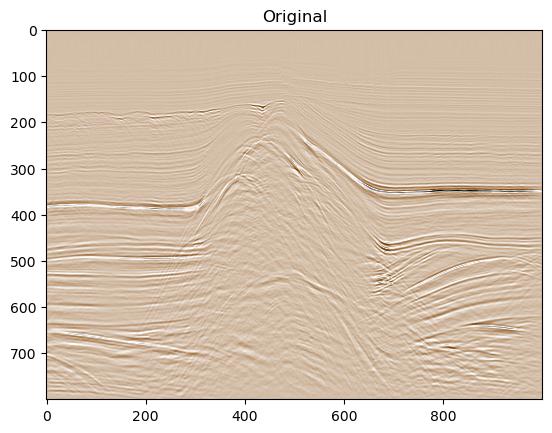

In [1]:
# First download data (Github allows file size < 25Mb)
# https://github.com/aaspip/data/blob/main/masha_field_800_1000.bin
# first read the data
def binread(fname,n1,n2=1,n3=1):
	'''
	
	EXAMPLE
	from pylib.io import binwrite,binread
	from pyseistr import gensyn
	din=gensyn();
	binwrite('data_400_1000.bin',din)
	
	data=binread('data_400_1000.bin',n1=400,n2=1000)
	import matplotlib.pyplot as plt
	plt.imshow(data);
	plt.show()
	'''
	import numpy as np
	fid=open(fname,"rb")
	data=np.fromfile(fid, dtype = np.float32, count = n1*n2*n3) ### remember double precision
	
	if n2==1 and n3==1:
		data=np.reshape(data,[n1],order='F')
	elif n3==1:
		data=np.reshape(data,[n1,n2],order='F')
	else:
		data=np.reshape(data,[n1,n2,n3],order='F')
	
	return data

original=binread('masha_field_800_1000.bin',n1=800,n2=1000,n3=1);

d1=0.004;d2=13.3; #in meter
o1=0;o2=0;

from matplotlib import pyplot as plt
from pyseistr import cseis
import numpy as np

plt.imshow(original,cmap=cseis(),aspect='auto');
plt.title('Original');
plt.show()


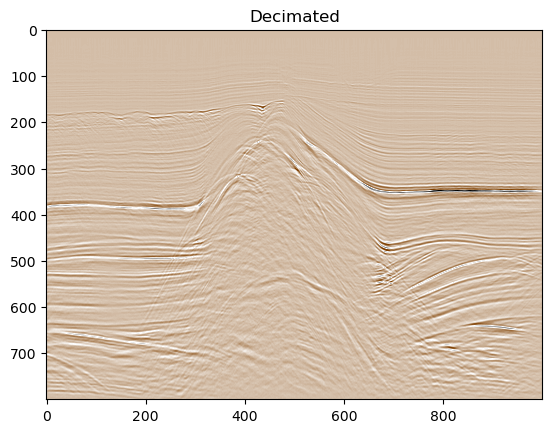

In [2]:
decimate=original[:,::2]
plt.imshow(original,cmap=cseis(),aspect='auto');
plt.title('Decimated');
plt.show()


In [3]:
decimate.shape

(800, 500)

In [4]:
# def nextpow2(N):
#     """ Function for finding the next power of 2 """
#     n = 1
#     while n < N: n *= 2
#     return n

# [n1,n2]=decimate.shape
# nf=nextpow2(n1);
# nf=int(nf)
# or 
nf=800

In [5]:
df=1/d1/nf
print('df=',df)

fx_original=np.fft.fft(decimate,nf,0);
DATA_FX0=np.zeros([nf,1000],dtype=np.complex_);

df= 0.3125


fx_original.shape (800, 500)


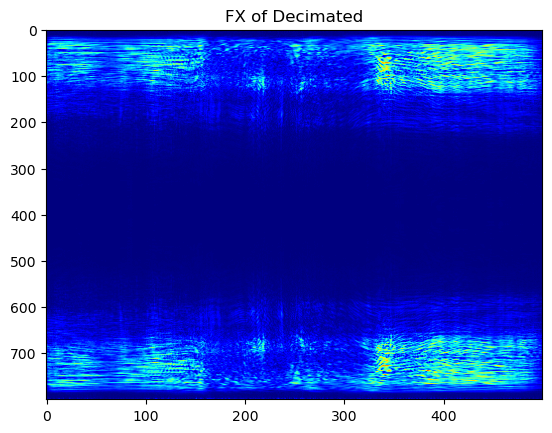

In [6]:
print('fx_original.shape',fx_original.shape)

plt.imshow(np.abs(fx_original),cmap='jet',aspect='auto');
plt.title('FX of Decimated');
plt.show()

fx_original.shape (401, 500)


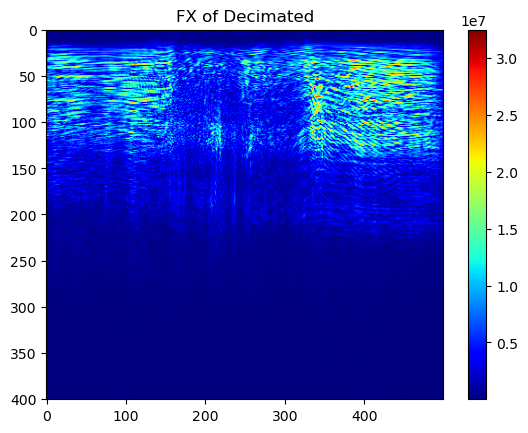

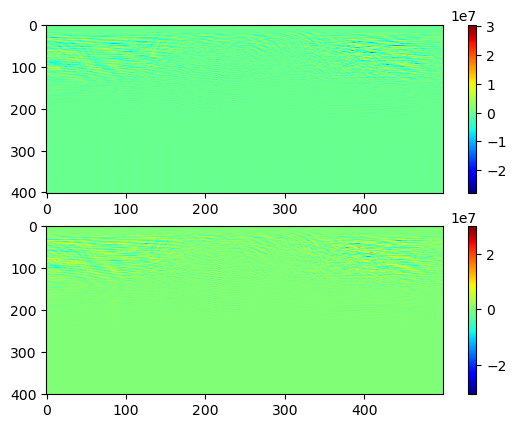

In [7]:
fx_original=fx_original[0:int(nf/2)+1]
print('fx_original.shape',fx_original.shape)

plt.imshow(np.abs(fx_original),cmap='jet',aspect='auto');
plt.title('FX of Decimated');plt.colorbar();
plt.show()

fx_original_real=np.real(fx_original);
fx_original_imag=np.imag(fx_original);
plt.subplot(2,1,1);
plt.imshow(fx_original_real,cmap='jet',aspect='auto');plt.colorbar();
plt.subplot(2,1,2);
plt.imshow(fx_original_imag,cmap='jet',aspect='auto');plt.colorbar();
plt.show()

In [8]:
from pyseistr import patch2d
patch_real=patch2d(fx_original_real[0:201,:],l1=1,l2=11,s1=1,s2=8)
patch_imag=patch2d(fx_original_imag[0:201,:],l1=1,l2=11,s1=1,s2=8)
patch=np.concatenate([patch_real,patch_imag],axis=1)
patch=patch.reshape(patch.shape[0],11,2,order='F')
print('patch.shape=',patch.shape)

patch.shape= (12663, 11, 2)


In [9]:
patch_input=patch[:,::2,:]
patch_output=patch[:,1::2,:]

In [10]:
print('patch_input.shape=',patch_input.shape)
print('patch_output.shape=',patch_output.shape)

patch_input.shape= (12663, 6, 2)
patch_output.shape= (12663, 5, 2)


In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape
from sklearn.model_selection import train_test_split

# Generating random data
x = patch_input  # Input data
y = patch_output  # Output data

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

# Define the fully connected neural network model
model = Sequential()
model.add(Flatten(input_shape=(6, 2)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='linear'))
model.add(Reshape((5, 2)))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_val, y_val))

# Evaluate the model
test_loss, test_mae = model.evaluate(x_val, y_val)
print(f"Validation Mean Absolute Error: {test_mae:.4f}")

# Predict using the model
predictions = model.predict(x_val)
print(f"Predictions shape: {predictions.shape}")


2024-10-07 13:41:14.227095: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/chenyk/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 13594150305792.0000 - mae: 2390022.0000 - val_loss: 3540677296128.0000 - val_mae: 1245583.5000
Epoch 2/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3141530288128.0000 - mae: 1169240.5000 - val_loss: 2924849135616.0000 - val_mae: 1123486.7500
Epoch 3/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2653824745472.0000 - mae: 1066887.5000 - val_loss: 2764248186880.0000 - val_mae: 1081722.1250
Epoch 4/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2600802975744.0000 - mae: 1048596.2500 - val_loss: 2698066001920.0000 - val_mae: 1064758.8750
Epoch 5/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2587976007680.0000 - mae: 1041890.5000 - val_loss: 2664933097472.0000 - val_mae: 1056994.1250
Epoch 6/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2462447828992.0000 - mae: 1022128.3125 - val_loss: 2632728182784.0000 - val_mae: 1047907.8750
Epoch 7/20
317/317 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2502762954752.0

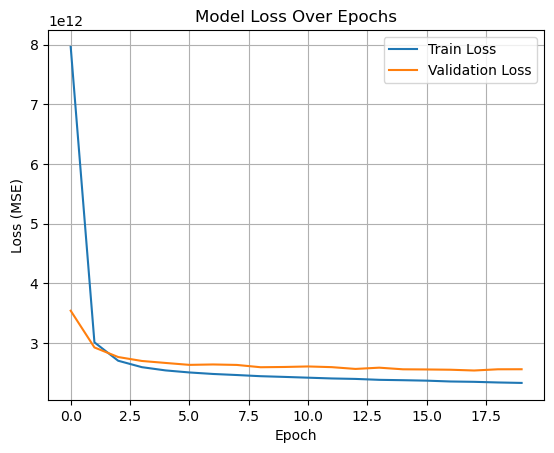

In [12]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
# normalizeFactor = np.linalg.norm(patch_reshaped.flatten(), 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


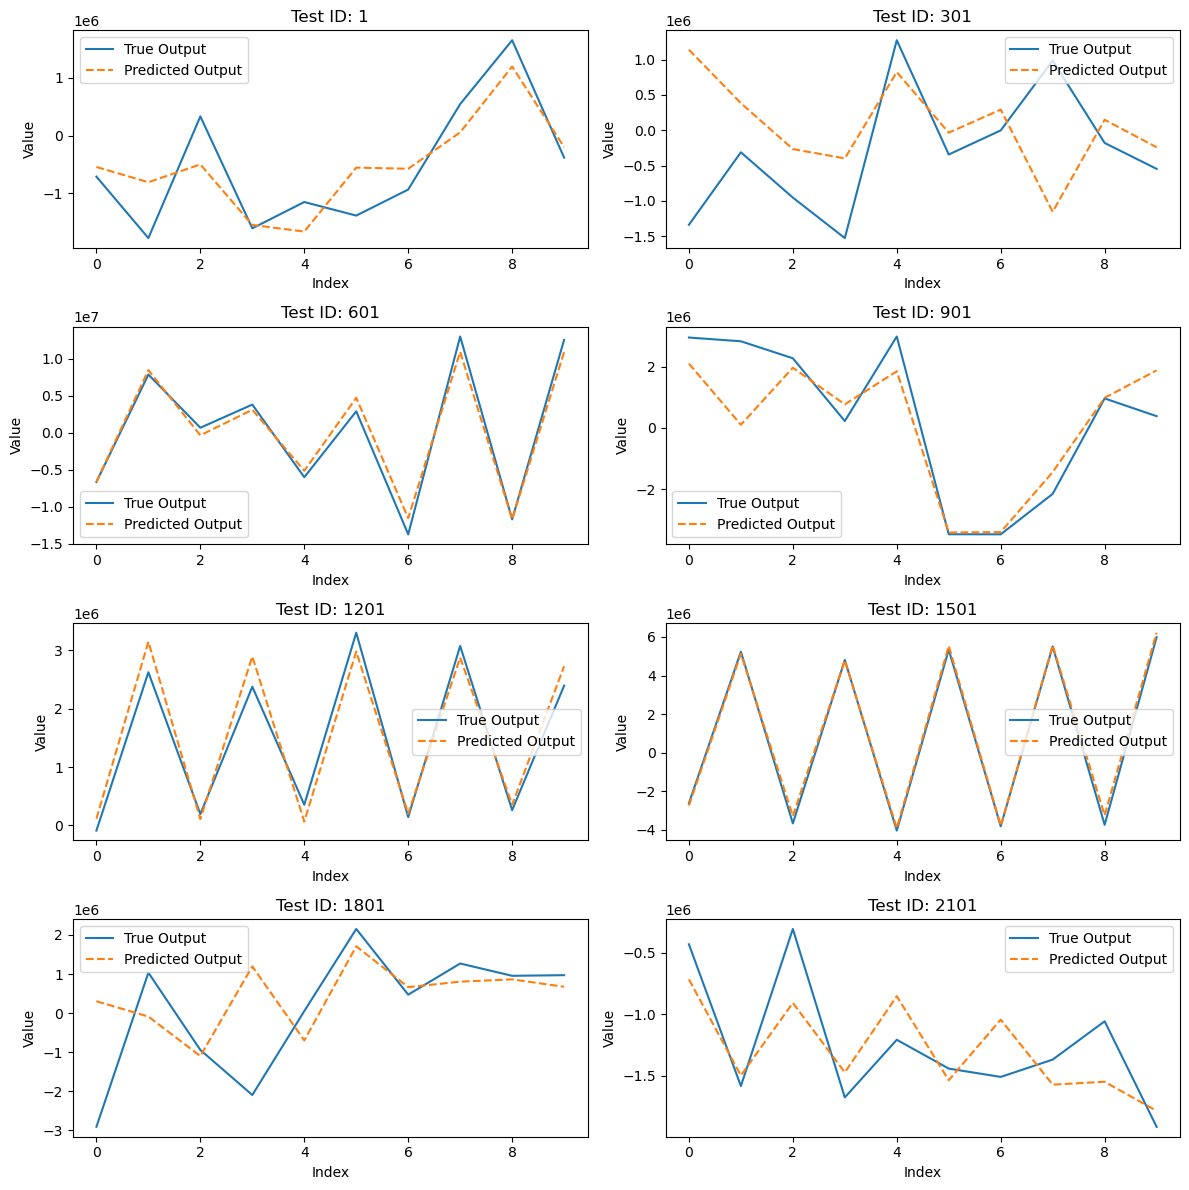

In [13]:
# Let's assume we want to compare 8 different test IDs
test_ids = [1, 301, 601, 901, 1201, 1501, 1801, 2101]

# Create a 4x2 plot grid
fig, axs = plt.subplots(4, 2, figsize=(12, 12))  # 4 rows, 2 columns of subplots

# Flatten the axs array for easier indexing
axs = axs.ravel()

for i, test_id in enumerate(test_ids):
    # Extract the true and predicted outputs for the given test_id
    test_output = y_val[test_id, :, :]
    pred_output = model.predict(x_val[test_id:test_id+1, :, :])

    # Plot on the ith subplot
    axs[i].plot(test_output.flatten(), label='True Output')
    axs[i].plot(pred_output.flatten(), label='Predicted Output', linestyle='--')

    # Add title and labels
    axs[i].set_title(f'Test ID: {test_id}')
    axs[i].set_xlabel('Index')
    axs[i].set_ylabel('Value')

    # Add a legend
    axs[i].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [15]:
# from tensorflow.keras.utils import plot_model

# plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# !pip install pydot

In [16]:
patch_real1=patch2d(fx_original_real,l1=1,l2=6,s1=1,s2=4)
patch_imag1=patch2d(fx_original_imag,l1=1,l2=6,s1=1,s2=4)
patch1=np.concatenate([patch_real1,patch_imag1],axis=1)
patch1=patch1.reshape(patch1.shape[0],6,2,order='F')
print('patch.shape=',patch1.shape)

patch.shape= (50125, 6, 2)


In [17]:
patch_pred = model.predict(patch1)

1567/1567 ━━━━━━━━━━━━━━━━━━━━ 1s 768us/step


In [18]:
print('patch_pred.shape',patch_pred.shape)
print('fx_original_real.shape',fx_original_real.shape)

patch_pred.shape (50125, 5, 2)
fx_original_real.shape (401, 500)


In [19]:
from pyseistr import patch2d_inv
patch_pred_real=patch_pred[:,:,0]
patch_pred_imag=patch_pred[:,:,1]
interpolated_real=patch2d_inv(patch_pred_real,401,500,l1=1,l2=5,s1=1,s2=4)
interpolated_imag=patch2d_inv(patch_pred_imag,401,500,l1=1,l2=5,s1=1,s2=4)

In [20]:
patch_pred.shape

(50125, 5, 2)

In [21]:
interpolated_imag.shape

(401, 500)

In [22]:
fx_interpolated=interpolated_real.astype('complex')
fx_interpolated.imag=interpolated_imag


fx_interpolated.shape (401, 500)


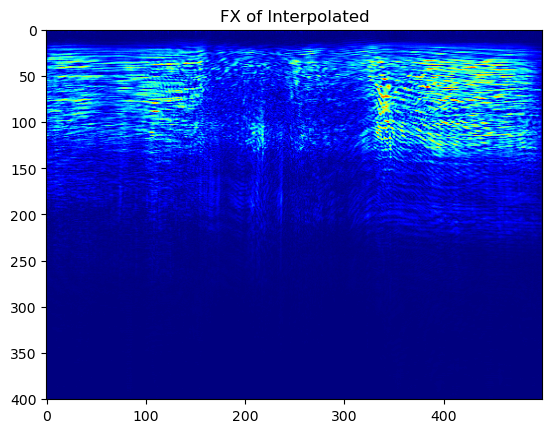

In [23]:
print('fx_interpolated.shape',fx_original.shape)

plt.imshow(np.abs(fx_interpolated),cmap='jet',aspect='auto');
plt.title('FX of Interpolated');
plt.show()

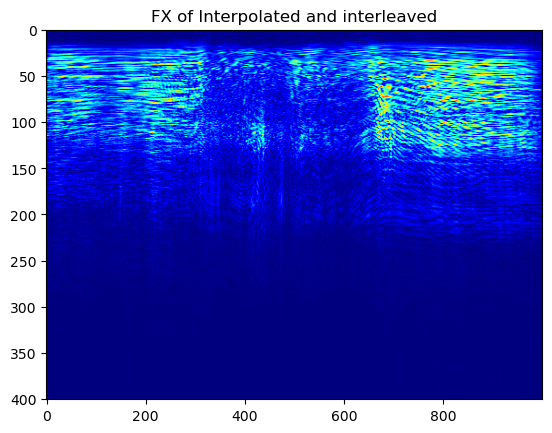

In [24]:
fx_interpolated_interleaved=np.zeros([401,1000],dtype='complex')
fx_interpolated_interleaved[:,::2]=fx_original;
fx_interpolated_interleaved[:,1::2]=fx_interpolated;

plt.imshow(np.abs(fx_interpolated_interleaved),cmap='jet',aspect='auto');
plt.title('FX of Interpolated and interleaved');
plt.show()

In [25]:
DATA_FX0[0:int(nf/2)+1]=fx_interpolated_interleaved

for k in range(int(nf/2)+2,nf+1):
    DATA_FX0[k-1,:] = np.conj(DATA_FX0[nf-k+1,:]);

#Back to TX (the output)
n1=800;n2=1000;
tx_interpolated=np.real(np.fft.ifft(DATA_FX0,nf,0));
tx_interpolated=tx_interpolated[0:n1,:];
print("tx_interpolated.shape",tx_interpolated.shape)

tx_interpolated.shape (800, 1000)


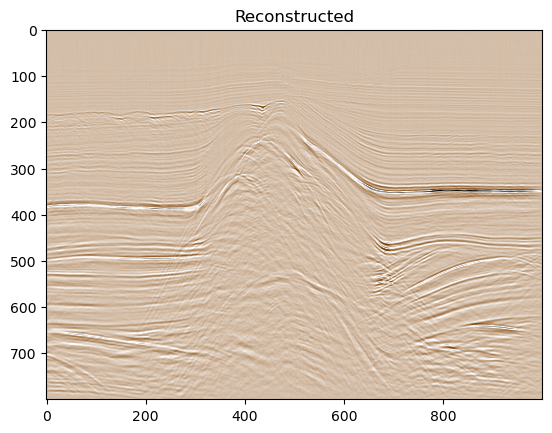

In [26]:
plt.imshow(tx_interpolated,cmap=cseis(),aspect='auto');
plt.title('Reconstructed');
plt.show()

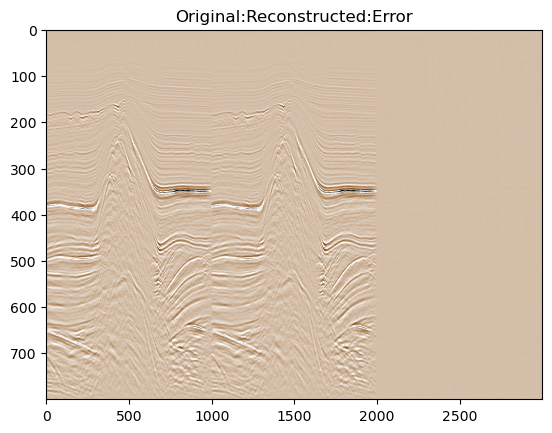

In [27]:
plt.imshow(np.concatenate([original,tx_interpolated,original-tx_interpolated],axis=1),cmap=cseis(),aspect='auto');
plt.title('Original:Reconstructed:Error');
plt.show()